In [35]:
import os
import sys; sys.path.append("~/HHbbgg_ETH_devel/Training/python") # to load packages
import training_utils as utils
import numpy as np
reload(utils)
import preprocessing_utils as preprocessing
reload(preprocessing)
import plotting_utils as plotting
reload(plotting)
import optimization_utils as optimization
reload(optimization)
import postprocessing_utils as postprocessing
reload(postprocessing)
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt


In [36]:
clf_trainings = []
plot_classifier_all = []
fpr_dipho_all,tpr_dipho_all = [],[]
fpr_gJets_all,tpr_gJets_all = [],[]
X_total_test_all,y_total_test_all,w_total_test_all = [],[],[]
labels=[]

In [37]:
year=1
dirs = ['ntuples_2016_20181203','ntuples_2017_20181203']
ntuples = dirs[year]
# "%" sign allows to interpret the rest as a system command
%env data=$utils.IO.ldata$ntuples
files = ! ls $data | sort -t_ -k 3 -n
if (year==0) : signal = [s for s in files if "SM_plus_reweighted_nodes_" in s ]
else : signal = [s for s in files if "SM_plus_nodes_" in s ]
diphotonJets = [s for s in files if "DiPhotonJetsBox_" in s]
#diphotonJets_1B = [s for s in files if "DiPhotonJetsBox1B" in s] # will use for limits
#diphotonJets_2B = [s for s in files if "DiPhotonJetsBox2B" in s] # will use for limits
gJets_lowPt = [s for s in files if "GJet_Pt-20to40" in s]
gJets_highPt = [s for s in files if "GJet_Pt-40" in s]

utils.IO.add_signal(ntuples,signal,1,'nodesCombined',year)
utils.IO.add_background(ntuples,diphotonJets,-1,'tagsDumper/trees/'+diphotonJets[0][diphotonJets[0].find('output_')+7:diphotonJets[0].find('.root')].replace('-','_')+'_13TeV_DoubleHTag_0',year)
utils.IO.add_background(ntuples,gJets_lowPt,-2,'tagsDumper/trees/'+gJets_lowPt[0][gJets_lowPt[0].find('output_')+7:gJets_lowPt[0].find('.root')].replace('-','_')+'_13TeV_DoubleHTag_0',year)                            
utils.IO.add_background(ntuples,gJets_highPt,-2,'tagsDumper/trees/'+gJets_highPt[0][gJets_highPt[0].find('output_')+7:gJets_highPt[0].find('.root')].replace('-','_')+'_13TeV_DoubleHTag_0',year)                           


for i in range(len(utils.IO.backgroundName)):        
    print "using background file n."+str(i)+": "+utils.IO.backgroundName[i]
for i in range(len(utils.IO.signalName)):    
    print "using signal file n."+str(i)+": "+utils.IO.signalName[i]

env: data=/shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_2017_20181203
using background file n.0: /shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_2017_20181203/output_DiPhotonJetsBox_MGG-80toInf_13TeV-Sherpa.root
using background file n.1: /shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_2017_20181203/output_GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8.root
using background file n.2: /shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_2017_20181203/output_GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8.root
using signal file n.0: /shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_2017_20181203/output_GluGluToHHTo2B2G_SM_plus_nodes_13TeV-madgraph.root


## Folder name where to store output for a specific training

In [38]:
outstr = "05_12_2018_commonTraining"
labels.append(outstr)
utils.IO.plotFolder = '/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/Training/plots/%s/'%outstr
if not os.path.exists(utils.IO.plotFolder):
    print utils.IO.plotFolder, "doesn't exist, creating it..."
    os.makedirs(utils.IO.plotFolder)

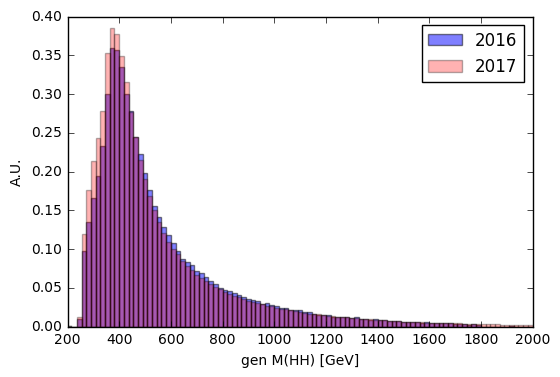

In [40]:
plt.clf()
doReweight2017 = True #reweight signal from 2017 to match 2016 (mix of nodes reweight with HH_mass at gen level)
if (year==1 and doReweight2017 == True):
    sigFiles = ['output_GluGluToHHTo2B2G_SM_plus_reweighted_nodes_13TeV-madgraph.root','output_GluGluToHHTo2B2G_SM_plus_nodes_13TeV-madgraph.root']
    genFrame2017=rpd.read_root(utils.IO.ldata+dirs[1]+'/'+sigFiles[1],'GenNodesCombined', columns = ['mhh','weight'])
    genFrame2016=rpd.read_root(utils.IO.ldata+dirs[0]+'/'+sigFiles[0],'GenNodesCombined', columns = ['mhh','weight'])
    recoFrame2016=rpd.read_root(utils.IO.ldata+dirs[0]+'/'+sigFiles[0],'nodesCombined', columns = ['MX','genMhh','weight'])
    recoFrame2017=rpd.read_root(utils.IO.ldata+dirs[1]+'/'+sigFiles[1],'nodesCombined', columns = ['MX','genMhh','weight'])

    
    n, bins, patches = plt.hist(genFrame2016['mhh'], np.linspace(200,2000,100), facecolor='b',weights=genFrame2016['weight'], alpha=0.5,normed=False,label='2016')
    plt.xlabel('gen M(HH) [GeV]')
    plt.ylabel('A.U.')
    n_2017, bins_2017, patches_2017 = plt.hist(genFrame2017['mhh'], bins=bins,weights=genFrame2017['weight'],facecolor='r', alpha=0.3,normed=False,label='2017')
    plt.legend(loc = 'upper right')
    plt.show()
    

In [41]:
from ROOT import TLorentzVector

#use noexpand for root expressions, it needs this file https://github.com/ibab/root_pandas/blob/master/root_pandas/readwrite.py
########################new code branches############################
#branch_names = 'leadingJet_bDis,subleadingJet_bDis,absCosThetaStar_CS,absCosTheta_bb,absCosTheta_gg,diphotonCandidatePtOverdiHiggsM,dijetCandidatePtOverdiHiggsM,customLeadingPhotonIDMVA,customSubLeadingPhotonIDMVA,leadingPhotonSigOverE,subleadingPhotonSigOverE,sigmaMOverMDecorr,PhoJetMinDr'.split(",") #set of variables March 2017 but regressed
branch_names = 'leadingJet_DeepCSV,subleadingJet_DeepCSV,absCosThetaStar_CS,absCosTheta_bb,absCosTheta_gg,diphotonCandidatePtOverdiHiggsM,dijetCandidatePtOverdiHiggsM,customLeadingPhotonIDMVA,customSubLeadingPhotonIDMVA,leadingPhotonSigOverE,subleadingPhotonSigOverE,sigmaMOverM,PhoJetMinDr'.split(",") #set of variables March 2017 but regressed
b_reg_branches = 'noexpand:(leadingJet_bRegNNResolution*1.4826),noexpand:(subleadingJet_bRegNNResolution*1.4826),noexpand:(sigmaMJets*1.4826)'.split(",")
branch_cuts = 'leadingJet_pt,subleadingJet_pt,leadingJet_bRegNNCorr,subleadingJet_bRegNNCorr,noexpand:(leadingJet_pt/leadingJet_bRegNNCorr),noexpand:(subleadingJet_pt/subleadingJet_bRegNNCorr)'.split(',')
cuts = 'leadingJet_pt>0'
#cuts = 'subleadingJet_pt>25'
######################

#event_branches = ['event','sigmaMOverM','noexpand:(dijetSigmaMOverM*1.4826)']
event_branches = ['event','weight','MX','leadingJet_hflav','leadingJet_pflav','subleadingJet_hflav','subleadingJet_pflav']

branch_names = branch_names + ['rho']
branch_names = branch_names+b_reg_branches
resolution_weighting = '' # None, gg or ggbb
doOverlapRemoval=False   #diphotons overlap removal if using b-enriched samples


branch_names = [c.strip() for c in branch_names]
print branch_names

event_bkg,event_sig = None,None
if (year==1 and doReweight2017 == True):
    preprocessing.set_signals(branch_names+event_branches+branch_cuts+['genMhh'],True,cuts)
    preprocessing.set_backgrounds(branch_names+event_branches+branch_cuts,True,cuts)
else :
    preprocessing.set_signals_and_backgrounds(branch_names+event_branches+branch_cuts,True,cuts)


if 'gg' in resolution_weighting : 
    preprocessing.weight_signal_with_resolution_all(branch='sigmaMOverM')
if 'bb' in resolution_weighting : 
    preprocessing.weight_signal_with_resolution_all(branch='(sigmaMJets*1.4826)')

if doOverlapRemoval == True:    
    for i in range(utils.IO.nBkg):
        if 'DiPhotonJetsBox_MGG' in utils.IO.bkgTreeName[i] : preprocessing.cleanOverlapDiphotons(utils.IO.bkgTreeName[i],utils.IO.background_df[i])        

if (year==1 and doReweight2017 == True):
    preprocessing.reweight_gen_mhh('mhh',genFrame2016,genFrame2017,utils.IO.signal_df[0],'genMhh')
            
#preprocessing.normalize_process_weights_all()
        
        
X_bkg,y_bkg,weights_bkg,event_bkg,X_sig,y_sig,weights_sig,event_sig=preprocessing.set_variables(branch_names,use_event_num=True)

info_file = open(utils.IO.plotFolder+"info_%s.txt"%outstr,"w") 
info_file.write("\n".join(branch_names))
info_file.write("Resolution weighting : %s\n"%resolution_weighting)
info_file.write("Cuts : %s\n"%cuts)
info_file.close()



X_bkg,y_bkg,weights_bkg,event_bkg = preprocessing.randomize(X_bkg,y_bkg,weights_bkg,event_num = np.asarray(event_bkg))
X_sig,y_sig,weights_sig,event_sig = preprocessing.randomize(X_sig,y_sig,weights_sig,event_num = np.asarray(event_sig))


#Get training and test samples based on event number : even/odd or %5, set in the function for now
y_total_train = preprocessing.get_total_training_sample_event_num(y_sig.reshape(-1,1),y_bkg,event_sig.reshape(-1,1),event_bkg).ravel()
X_total_train = preprocessing.get_total_training_sample_event_num(X_sig,X_bkg,event_sig.reshape(-1,),event_bkg.reshape(-1,))

y_total_test = preprocessing.get_total_test_sample_event_num(y_sig.reshape(-1,1),y_bkg,event_sig.reshape(-1,1),event_bkg).ravel()
X_total_test = preprocessing.get_total_test_sample_event_num(X_sig,X_bkg,event_sig.reshape(-1,),event_bkg.reshape(-1,))

w_total_train = preprocessing.get_total_training_sample_event_num(weights_sig.reshape(-1,1),weights_bkg.reshape(-1,1),event_sig.reshape(-1,1),event_bkg).ravel()
w_total_test = preprocessing.get_total_test_sample_event_num(weights_sig.reshape(-1,1),weights_bkg.reshape(-1,1),event_sig.reshape(-1,1),event_bkg).ravel()


['leadingJet_DeepCSV', 'subleadingJet_DeepCSV', 'absCosThetaStar_CS', 'absCosTheta_bb', 'absCosTheta_gg', 'diphotonCandidatePtOverdiHiggsM', 'dijetCandidatePtOverdiHiggsM', 'customLeadingPhotonIDMVA', 'customSubLeadingPhotonIDMVA', 'leadingPhotonSigOverE', 'subleadingPhotonSigOverE', 'sigmaMOverM', 'PhoJetMinDr', 'rho', 'noexpand:(leadingJet_bRegNNResolution*1.4826)', 'noexpand:(subleadingJet_bRegNNResolution*1.4826)', 'noexpand:(sigmaMJets*1.4826)']
using tree:nodesCombined
using tree:tagsDumper/trees/DiPhotonJetsBox_MGG_80toInf_13TeV_Sherpa_13TeV_DoubleHTag_0
using tree:tagsDumper/trees/GJet_Pt_20to40_DoubleEMEnriched_MGG_80toInf_TuneCP5_13TeV_Pythia8_13TeV_DoubleHTag_0
using tree:tagsDumper/trees/GJet_Pt_40toInf_DoubleEMEnriched_MGG_80toInf_TuneCP5_13TeV_Pythia8_13TeV_DoubleHTag_0


In [42]:
print '-'*10,'For train','-'*10
print 'Signal : ',y_total_train[np.where(y_total_train==1)].shape[0]
print 'Bkg : ',y_total_train[np.where(y_total_train!=1)].shape[0]
print '-'*10,'For test','-'*10
print 'Signal : ',y_total_test[np.where(y_total_test==1)].shape[0]
print 'Bkg : ',y_total_test[np.where(y_total_test!=1)].shape[0]

X_total_test_all.append(X_total_test)
y_total_test_all.append(y_total_test)
w_total_test_all.append(w_total_test)

---------- For train ----------
Signal :  445052
Bkg :  1638684
---------- For test ----------
Signal :  444453
Bkg :  409489


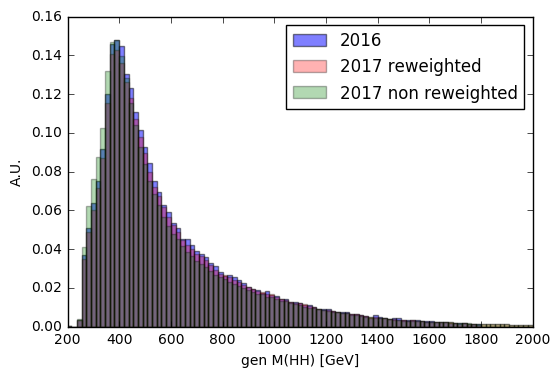

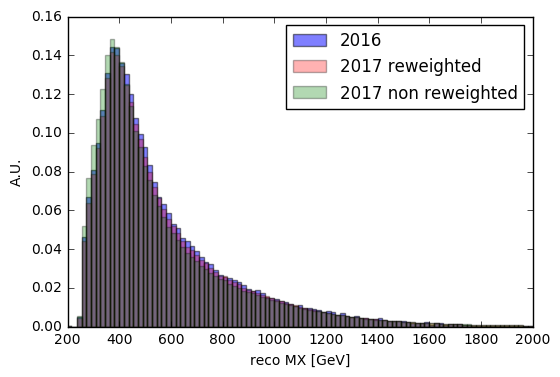

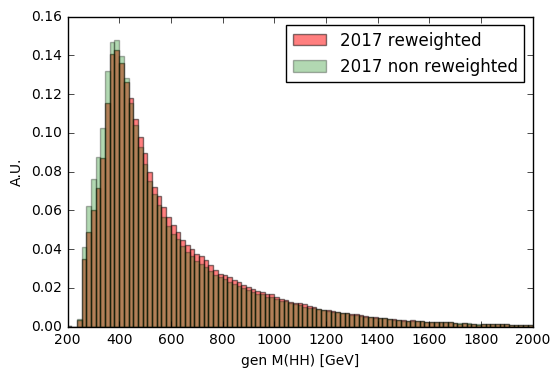

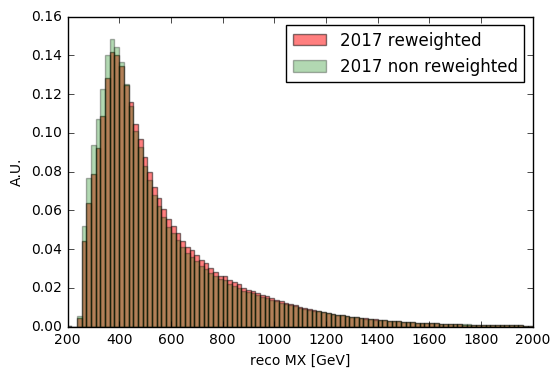

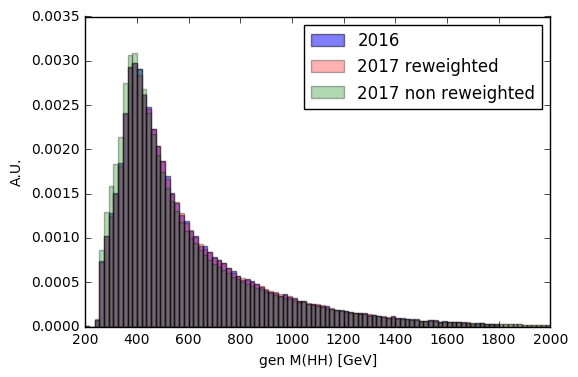

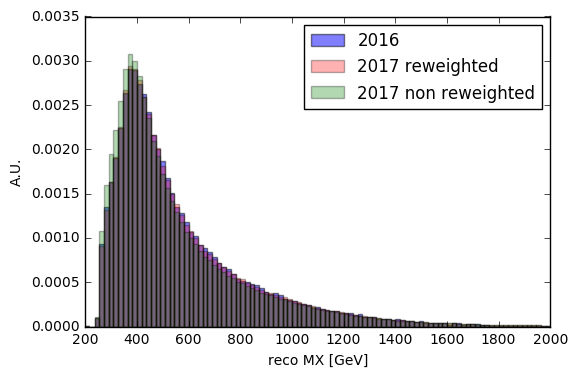

In [43]:
plt.clf()
n, bins, patches = plt.hist(recoFrame2016['genMhh'], np.linspace(200,2000,100), facecolor='b',weights=recoFrame2016['weight'], alpha=0.5,normed=False,label='2016')
plt.xlabel('gen M(HH) [GeV]')
plt.ylabel('A.U.')
n_2017, bins_2017, patches_2017 = plt.hist(utils.IO.signal_df[0]['genMhh'], bins=bins,weights=utils.IO.signal_df[0]['weight'],facecolor='r', alpha=0.3,normed=False,label='2017 reweighted')
n, bins, patches = plt.hist(recoFrame2017['genMhh'], bins=bins, facecolor='g',weights=recoFrame2017['weight'], alpha=0.3,normed=False,label='2017 non reweighted')
plt.legend(loc = 'upper right')
plt.savefig(utils.IO.plotFolder+"compare_2016_2017_1_"+"_"+str(outstr)+".pdf" ,bbox_inches='tight')
plt.savefig(utils.IO.plotFolder+"compare_2016_2017_1_"+"_"+str(outstr)+".png", bbox_inches='tight')
plt.show()

plt.clf()
n, bins, patches = plt.hist(recoFrame2016['MX'], np.linspace(200,2000,100), facecolor='b',weights=recoFrame2016['weight'], alpha=0.5,normed=False,label='2016')
plt.xlabel('reco MX [GeV]')
plt.ylabel('A.U.')
n_2017, bins_2017, patches_2017 = plt.hist(utils.IO.signal_df[0]['MX'], bins=bins,weights=utils.IO.signal_df[0]['weight'],facecolor='r', alpha=0.3,normed=False,label='2017 reweighted')
n_2017, bins_2017, patches_2017 = plt.hist(recoFrame2017['MX'], bins=bins,weights=recoFrame2017['weight'],facecolor='g', alpha=0.3,normed=False,label='2017 non reweighted')
plt.legend(loc = 'upper right')
plt.savefig(utils.IO.plotFolder+"compare_2016_2017_2_"+"_"+str(outstr)+".pdf")
plt.savefig(utils.IO.plotFolder+"compare_2016_2017_2_"+"_"+str(outstr)+".png")
plt.show()



#n, bins, patches = plt.hist(recoFrame2016['hh_m'], np.linspace(200,2000,100), facecolor='b',weights=recoFrame2016['weight'], alpha=0.5,normed=False,label='2016')
plt.xlabel('gen M(HH) [GeV]')
plt.ylabel('A.U.')
n_2017, bins_2017, patches_2017 = plt.hist(utils.IO.signal_df[0]['genMhh'], np.linspace(200,2000,100),weights=utils.IO.signal_df[0]['weight'],facecolor='r', alpha=0.5,normed=False,label='2017 reweighted')
n, bins, patches = plt.hist(recoFrame2017['genMhh'], bins=bins, facecolor='g',weights=recoFrame2017['weight'], alpha=0.3,normed=False,label='2017 non reweighted')
plt.legend(loc = 'upper right')
plt.savefig(utils.IO.plotFolder+"compare_2016_2017_3_"+"_"+str(outstr)+".pdf")
plt.savefig(utils.IO.plotFolder+"compare_2016_2017_3_"+"_"+str(outstr)+".png")
plt.show()


#n, bins, patches = plt.hist(recoFrame2016['MX'], np.linspace(200,2000,100), facecolor='b',weights=recoFrame2016['weight'], alpha=0.5,normed=False,label='2016')
plt.xlabel('reco MX [GeV]')
plt.ylabel('A.U.')
n_2017, bins_2017, patches_2017 = plt.hist(utils.IO.signal_df[0]['MX'], np.linspace(200,2000,100),weights=utils.IO.signal_df[0]['weight'],facecolor='r', alpha=0.5,normed=False,label='2017 reweighted')
n_2017, bins_2017, patches_2017 = plt.hist(recoFrame2017['MX'], bins=bins,weights=recoFrame2017['weight'],facecolor='g', alpha=0.3,normed=False,label='2017 non reweighted')
plt.legend(loc = 'upper right')
plt.savefig(utils.IO.plotFolder+"compare_2016_2017_4_"+"_"+str(outstr)+".pdf")
plt.savefig(utils.IO.plotFolder+"compare_2016_2017_4_"+"_"+str(outstr)+".png")
plt.show()


n, bins, patches = plt.hist(recoFrame2016['genMhh'], np.linspace(200,2000,100), facecolor='b',weights=recoFrame2016['weight'], alpha=0.5,normed=True,label='2016')
plt.xlabel('gen M(HH) [GeV]')
plt.ylabel('A.U.')
n_2017, bins_2017, patches_2017 = plt.hist(utils.IO.signal_df[0]['genMhh'], bins=bins,weights=utils.IO.signal_df[0]['weight'],facecolor='r', alpha=0.3,normed=True,label='2017 reweighted')
n_2017, bins_2017, patches_2017 = plt.hist(recoFrame2017['genMhh'], bins=bins,weights=recoFrame2017['weight'],facecolor='g', alpha=0.3,normed=True,label='2017 non reweighted')
plt.legend(loc = 'upper right')
plt.savefig(utils.IO.plotFolder+"compare_2016_2017_5_"+"_"+str(outstr)+".pdf")
plt.savefig(utils.IO.plotFolder+"compare_2016_2017_5_"+"_"+str(outstr)+".png")
plt.show()


n, bins, patches = plt.hist(recoFrame2016['MX'], np.linspace(200,2000,100), facecolor='b',weights=recoFrame2016['weight'], alpha=0.5,normed=True,label='2016')
plt.xlabel('reco MX [GeV]')
plt.ylabel('A.U.')
n_2017, bins_2017, patches_2017 = plt.hist(utils.IO.signal_df[0]['MX'], bins=bins,weights=utils.IO.signal_df[0]['weight'],facecolor='r', alpha=0.3,normed=True,label='2017 reweighted')
n_2017, bins_2017, patches_2017 = plt.hist(recoFrame2017['MX'], bins=bins,weights=recoFrame2017['weight'],facecolor='g', alpha=0.3,normed=True,label='2017 non reweighted')
plt.legend(loc = 'upper right')
plt.savefig(utils.IO.plotFolder+"compare_2016_2017_6_"+"_"+str(outstr)+".pdf")
plt.savefig(utils.IO.plotFolder+"compare_2016_2017_6_"+"_"+str(outstr)+".png")
plt.show()



In [44]:
#Acceptance reco 2016 and 2017

n, bins, patches = plt.hist(recoFrame2016['MX'], np.linspace(200,2000,100), facecolor='b',weights=recoFrame2016['weight'], alpha=0.5,normed=False,label='2016')
plt.xlabel('reco MX [GeV]')
plt.ylabel('A.U.')
n_2017_weighted, bins_2017_weighted, patches_2017_weighted = plt.hist(utils.IO.signal_df[0]['MX'], bins=bins,weights=utils.IO.signal_df[0]['weight'],facecolor='r', alpha=0.3,normed=False,label='2017 reweighted')
n_2017, bins_2017, patches_2017 = plt.hist(recoFrame2017['MX'], bins=bins,weights=recoFrame2017['weight'],facecolor='g', alpha=0.3,normed=False,label='2017 non reweighted')


bin_width = (2000.-200)/100.
integral = bin_width * sum(n[0:100])
integral_2017 = bin_width * sum(n_2017[0:100])
integral_2017_weighted = bin_width * sum(n_2017_weighted[0:100])
print integral
print integral_2017
print integral_2017_weighted

49.19637510190287
47.67894309014082
47.68148002316308


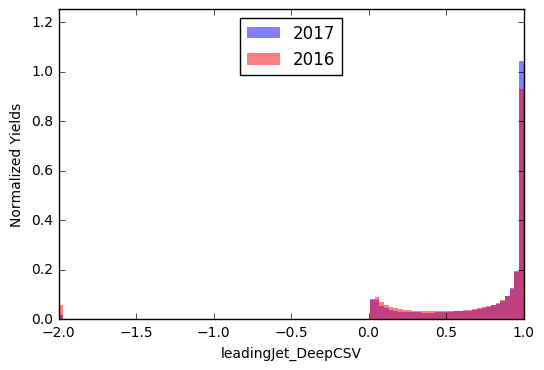

In [82]:
#Plot 2016 vs 2017 :
plt.clf()
br_names = [item.replace('noexpand:','') for item in branch_names]
recoFrame2016_full=rpd.read_root(utils.IO.ldata+dirs[0]+'/'+sigFiles[0],'nodesCombined',columns=branch_names+['weight','MX','genMhh'])
plotting.plot_input_variables_weights(utils.IO.signal_df[0][br_names].values,recoFrame2016_full[br_names].values,utils.IO.signal_df[0]['weight'].values.reshape(-1,),recoFrame2016_full['weight'].values.reshape(-1,),branch_names,None,100,'_2016_2017_mix_nodes_genMhhReweighted',labels=['2017','2016'],normalize=False)

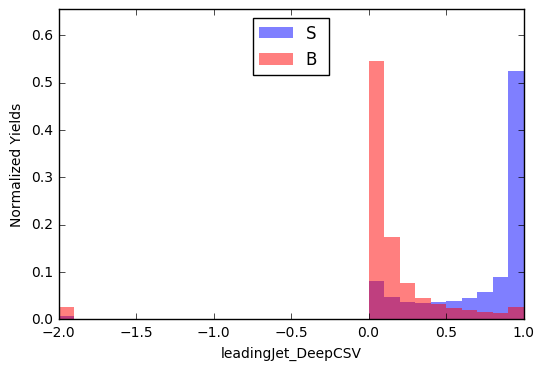

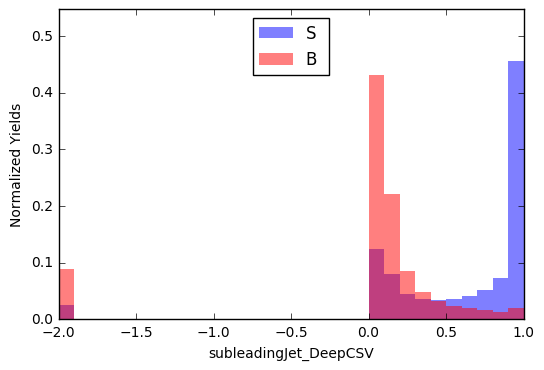

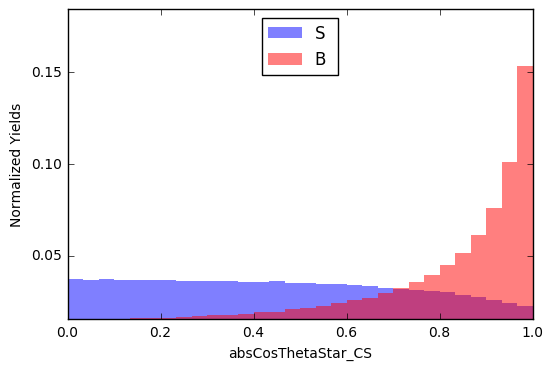

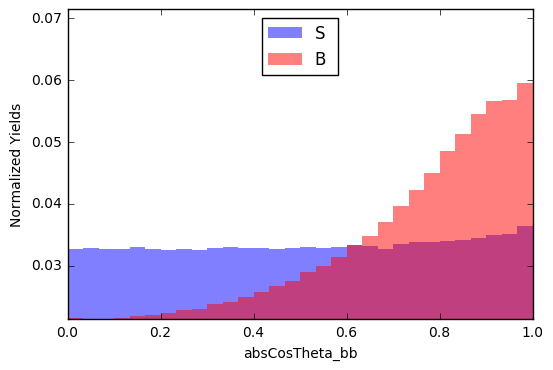

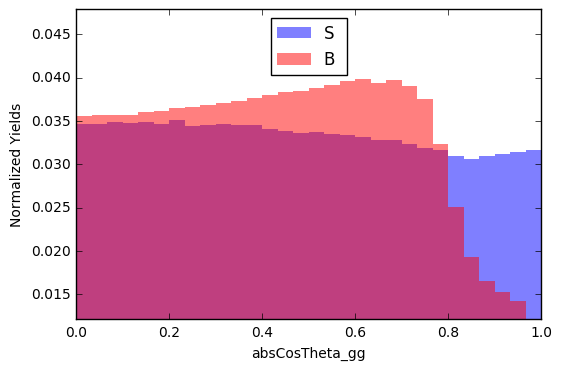

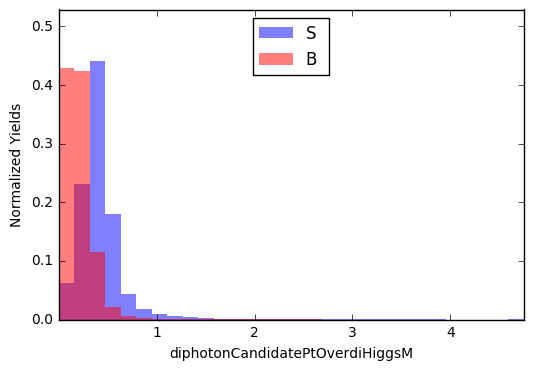

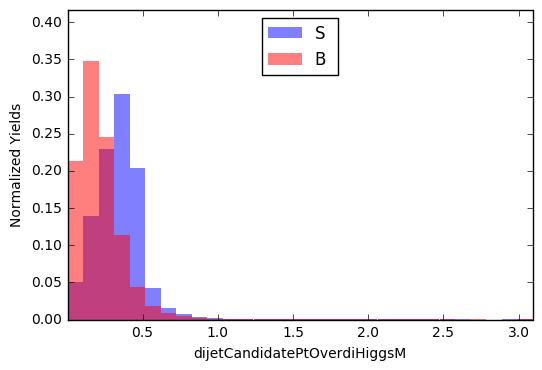

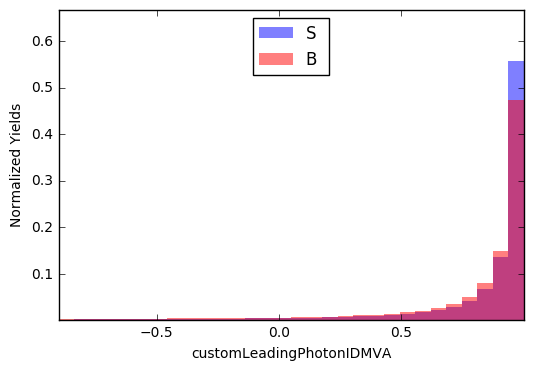

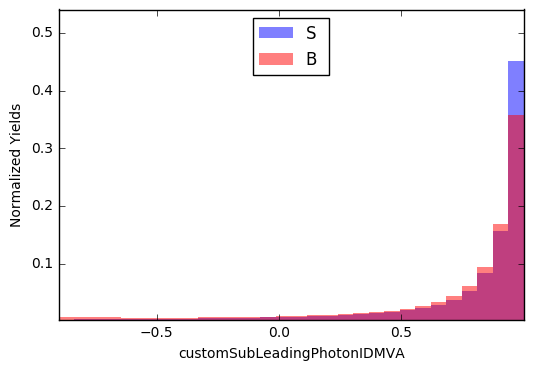

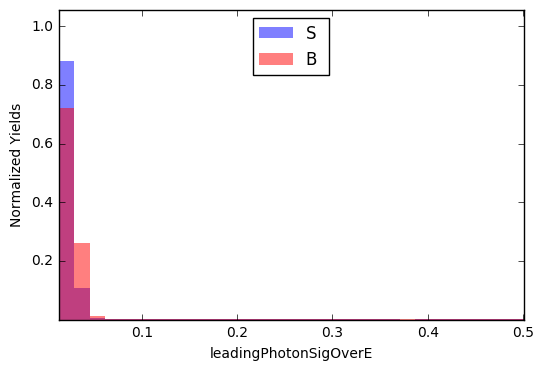

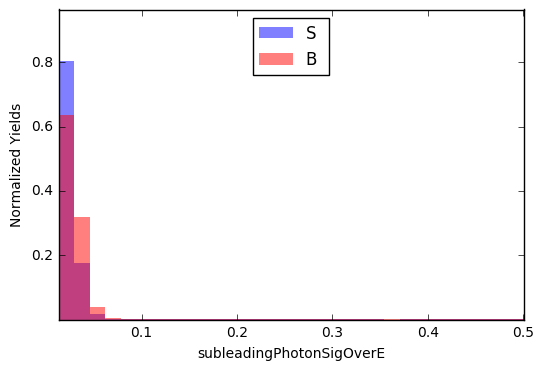

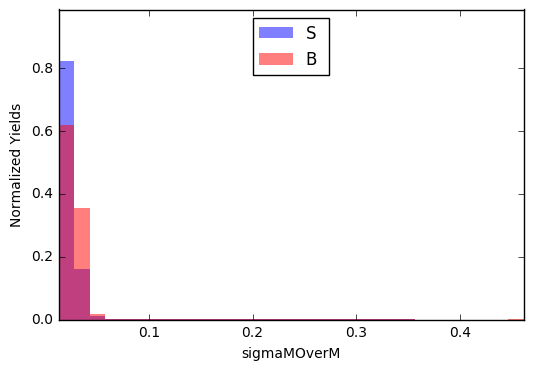

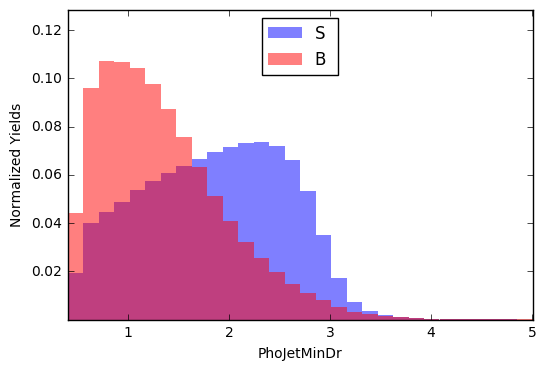

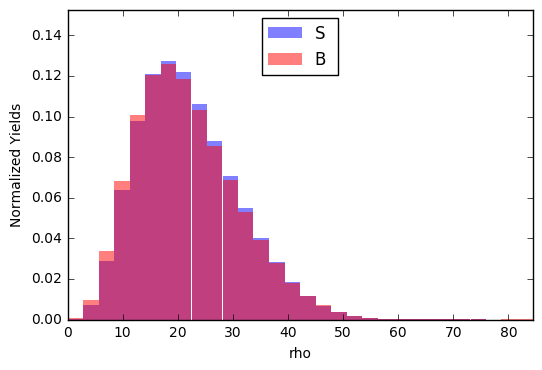

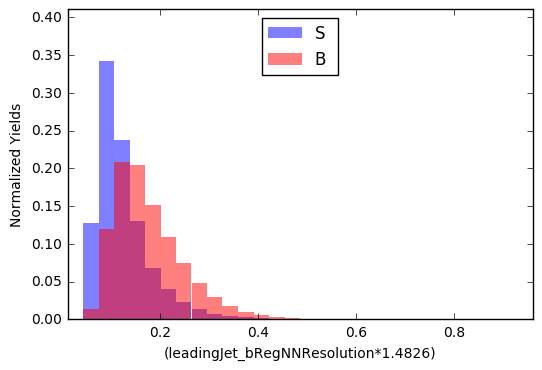

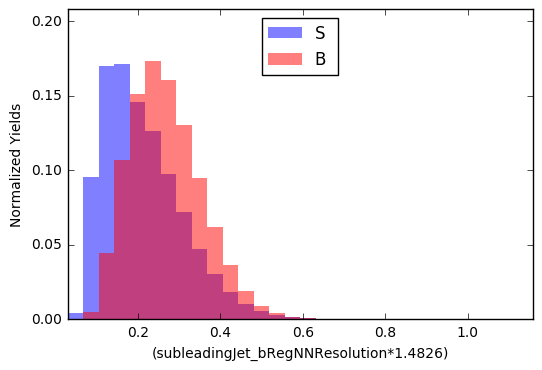

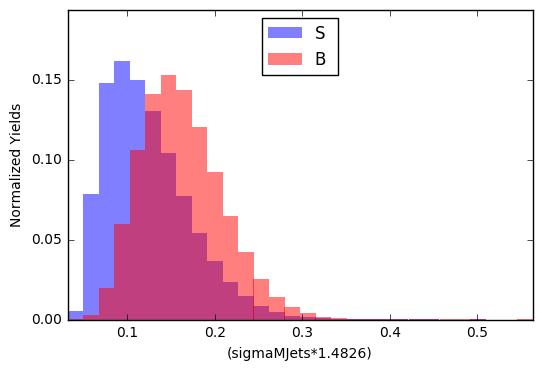

In [83]:
plotting.plot_input_variables(X_sig,X_bkg,branch_names+branch_cuts,None,30,'signalBkg_2017')

In [195]:
########final optimization with all fixed#######
from sklearn.externals import joblib
import xgboost as xgb
#optimized parameters

clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=10, min_child_weight=1e-05, missing=None,
       n_estimators=1000, n_jobs=1, nthread=20, objective='binary:logistic',
       random_state=0, reg_alpha=0.0, reg_lambda=0.1, scale_pos_weight=1,
       seed=0, silent=True, subsample=1)

#the smallest classifier from optimized grid
grid={'reg_alpha': 0.0, 'learning_rate': 0.2, 'min_child_weight': 0.0001, 'n_estimators': 1000, 'reg_lambda': 0.05, 'max_depth': 3, 'gamma': 0}
clf.set_params(**grid)

clf.fit(X_total_train,y_total_train, sample_weight=w_total_train)
joblib.dump(clf, os.path.expanduser('/shome/nchernya/HHbbgg_ETH_devel/Training/output_files/training_with_%s.pkl'%outstr), compress=9)
clf_trainings.append(clf)

In [196]:
clf_trainings

[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
        max_depth=3, min_child_weight=0.0001, missing=None,
        n_estimators=1000, n_jobs=1, nthread=20, objective='multi:softprob',
        random_state=0, reg_alpha=0.0, reg_lambda=0.05, scale_pos_weight=1,
        seed=0, silent=True, subsample=1)]

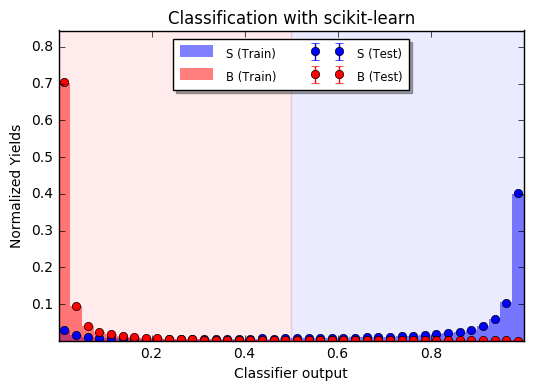

In [48]:
plt.clf()
plot_classifier = plotting.plot_classifier_output(clf,X_total_train,X_total_test,y_total_train,y_total_test,outString=outstr)
plt.show()

plot_classifier_all.append(plot_classifier)

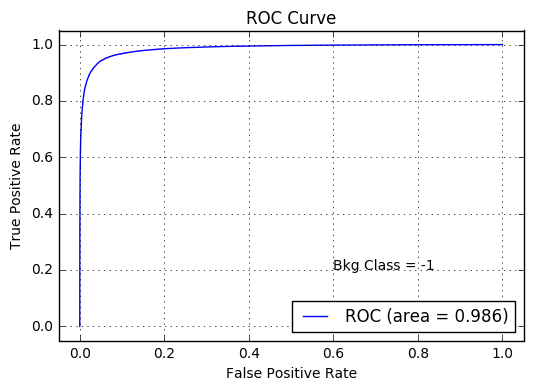

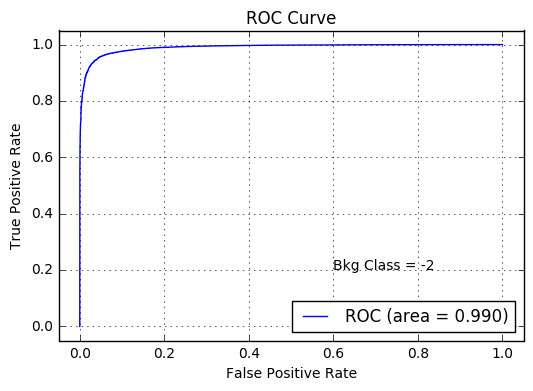

In [198]:
##if we want to evaluate different trainings on different sets : 

fpr_dipho,tpr_dipho = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-1,outString=outstr,weights=w_total_test)
plt.show()
fpr_gJets,tpr_gJets = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-2,outString=outstr,weights=w_total_test)
plt.show()

fpr_dipho_all.append(fpr_dipho)
tpr_dipho_all.append(tpr_dipho)
fpr_gJets_all.append(fpr_gJets)
tpr_gJets_all.append(tpr_gJets)

In [44]:
#if we want to evaluate on the same set different trainings : 
for clf in clf_trainings:
    fpr_dipho,tpr_dipho = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-1,outString=outstr,weights=w_total_test)
    fpr_gJets,tpr_gJets = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-2,outString=outstr,weights=w_total_test)

    fpr_dipho_all.append(fpr_dipho)
    tpr_dipho_all.append(tpr_dipho)
    fpr_gJets_all.append(fpr_gJets)
    tpr_gJets_all.append(tpr_gJets)

In [45]:
utils.IO.plotFolder = '/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/Training/plots/%s/'%outstr

In [ ]:
print labels
labels[0][labels[0].find('les')+4:]

In [ ]:
labels_legend = [labels[i][labels[i].find('bles')+4:] for i in range(0,len(labels))]
labels_legend = [labels[i] for i in range(0,len(labels))]

In [46]:
labels_legend = ['gg,g+jets','gg,gg+b-jets,g+jets']
labels = labels_legend

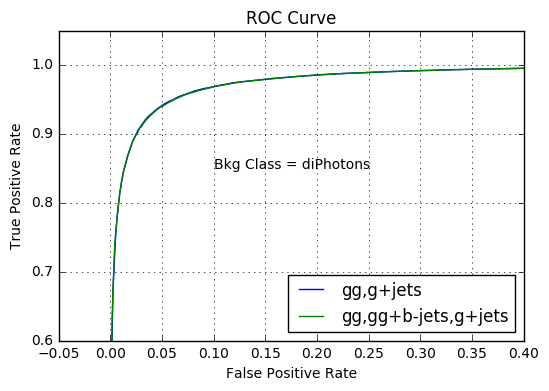

In [49]:
plt.clf()
for i in range(0,len(labels)):
    plt.plot(fpr_dipho_all[i], tpr_dipho_all[i], lw=1, label=labels_legend[i])


plt.xlim([-0.05, 0.4])
plt.ylim([0.6, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.text(0.1,0.85, 'Bkg Class = diPhotons')
plt.grid()
outString = "comparison_diphotons_vs_benriched_diphotonsRoc"
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".png")
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".pdf")
plt.show()

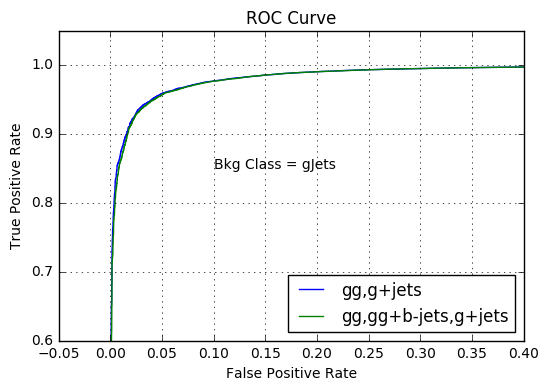

In [50]:
for i in range(0,len(labels)):
    plt.plot(fpr_gJets_all[i], tpr_gJets_all[i], lw=1, label=labels_legend[i])


plt.xlim([-0.05, 0.4])
plt.ylim([0.6, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.text(0.1,0.85, 'Bkg Class = gJets')
plt.grid()
outString = "comparison_diphotons_vs_benriched_gJetsRoc"
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".png")
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".pdf")
plt.show()

In [ ]:
X_bkg[np.where(event_bkg%2==0),:][0]